# Amazon Fine Food Reviews Preprocessing

This IPython notebook consists code for preprocessing of text, conversion of text into vectors and saving that information for further use.

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

## Public Information - 

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.
  1. Number of reviews: 568,454
  2. Number of users: 256,059
  3. Number of products: 74,258
  4. Timespan: Oct 1999 - Oct 2012
  5. Number of Attributes/Columns in data: 10

### Attribute Information -

  1. Id
  2. ProductId - unique identifier for the product
  3. UserId - unqiue identifier for the user
  4. ProfileName
  5. HelpfulnessNumerator - number of users who found the review helpful
  6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
  7. Score - rating between 1 and 5
  8. Time - timestamp for the review
  9. Summary - brief summary of the review
  10. Text - text of the review

### Current Objective - 
  Go through the reviews and perform preprocessing, convert them into vectors and save them for future use.


# [1] Reading Data

## [1.1] Loading data and libraries

In [24]:
#importing necessary libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import missingno as msno

from nltk.stem.wordnet import WordNetLemmatizer
import re
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import nltk
import pickle

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from concurrent import futures

from numba import jit

import os
from tqdm import tqdm

In [9]:
# setting path
par_path = os.path.normpath(os.getcwd() + os.sep + os.pardir)
dir_path = os.path.join(par_path, '0.datasets', 'pkl_dumps')
dir_path

'D:\\appliedAI\\0.assignments\\0.datasets\\pkl_dumps'

In [10]:
#connecting to sqlite db
con = sqlite3.connect(os.path.join(dir_path, 'database.sqlite'))

#filtering only positive and negative reviews
data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3", con)

print("Shape of data:", data.shape)

#scores < 3 are considered to be negative reviews and > 3 are considered to be positive reviews
data.head()

Shape of data: (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Missing values

Missing values? Ans - False


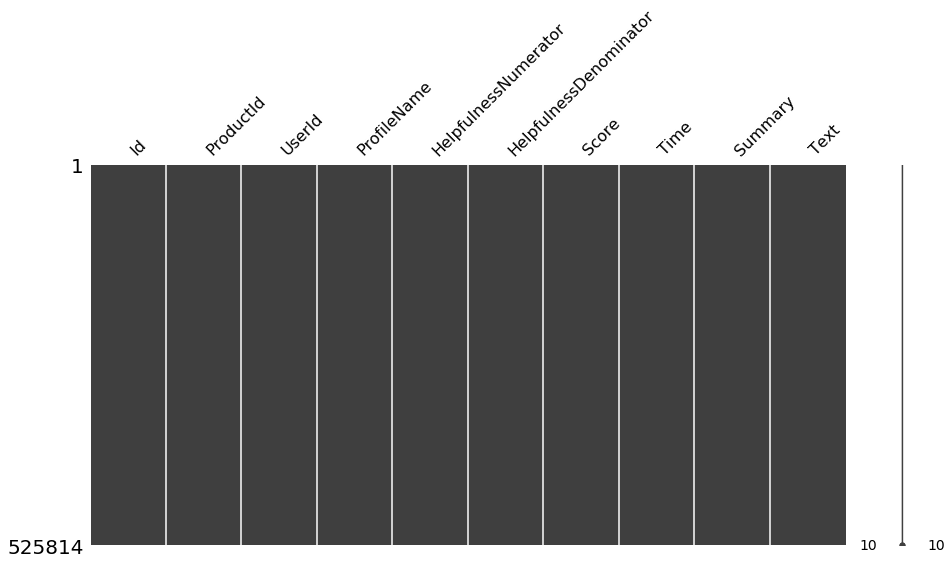

In [11]:
#let's just check, just in case if any
print("Missing values? Ans -", data.isnull().values.any())

#visualizing it
msno.matrix(data, figsize=(15,7))

## [2.2] Data cleaning: Multiple reviews for the same product by same person

In [12]:
df = data.copy()
df['ProdUser'] = df['ProductId'] + df['UserId']
df[df['ProdUser'].duplicated(keep=False)].sort_values(
    'ProdUser', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last'
)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProdUser
157863,171174,7310172001,AE9ZBY7WW3LIQ,W. K. Ota,0,0,4,1182902400,Best snack item for my dog.,Otter and I are very happy with this product. ...,7310172001AE9ZBY7WW3LIQ
157871,171183,7310172001,AE9ZBY7WW3LIQ,W. K. Ota,5,13,1,1219363200,Why sbould I get crums?,I selected this company over the other even th...,7310172001AE9ZBY7WW3LIQ
157912,171228,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",5,7,5,1233360000,NO waste at all--- all dogs love liver treats-...,Freeze dried liver has a hypnotic effect on do...,7310172001AJD41FBJD9010
157841,171152,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,dogs LOVE it-- best treat for rewards and tra...,Freeze dried liver has a hypnotic effect on do...,7310172001AJD41FBJD9010
157842,171153,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...,7310172001AJD41FBJD9010
157843,171154,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...,7310172001AJD41FBJD9010
157876,171189,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",39,51,5,1233360000,NO waste at all ---- great for training ----...,Freeze dried liver has a hypnotic effect on do...,7310172001AJD41FBJD9010
157908,171223,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",1,1,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...,7310172001AJD41FBJD9010
200626,217414,7310172101,AE9ZBY7WW3LIQ,W. K. Ota,5,13,1,1219363200,Why sbould I get crums?,I selected this company over the other even th...,7310172101AE9ZBY7WW3LIQ
200618,217405,7310172101,AE9ZBY7WW3LIQ,W. K. Ota,0,0,4,1182902400,Best snack item for my dog.,Otter and I are very happy with this product. ...,7310172101AE9ZBY7WW3LIQ


### Obeservations

1.   There are some instances where a user has written more than one review for the same product.
2.   We can remove the one which has less Helpfulness but lets keep all and treat it as review from a different user.
3.   Will definitely have to remove same reviews because it is just redundant data.



In [13]:
#Sorting data according to ProductId in ascending order
data = data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

## [2.3] Data cleaning: Deduplication - 1

In [14]:
#Deduplication of entries
data=data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
data.shape

(364173, 10)

In [15]:
data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."


## [2.4] Data cleaning: Deduplication - 2
Same reviews on multiple products with different timestamps

In [16]:
data[data['Text'].duplicated(keep=False)].sort_values(
    'Text', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last'
)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
67574,73444,B0046IISFG,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",1,1,5,1342915200,Great Diabetic Friendly Sweetwner - Highly Rec...,"""Erythritol"" has become one of our favorite su..."
287090,311004,B001EO6FPU,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",9,9,5,1297036800,Great Diabetic Friendly Sweetener - Highly Rec...,"""Erythritol"" has become one of our favorite su..."
302818,327982,B0000CEQ6H,A281NPSIMI1C2R,"Rebecca of Amazon ""The Rebecca Review""",3,3,5,1084492800,Superior for Bread Baking,"""We use and believe in stone milling because n..."
494235,534333,B0000CEQ72,A281NPSIMI1C2R,"Rebecca of Amazon ""The Rebecca Review""",1,1,5,1093651200,Bob's Red Mill Whole Wheat Flour,"""We use and believe in stone milling because n..."
387315,418839,B000FZYSVC,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",1,1,5,1173052800,Perfect Morning Tea (Caffeinated),*****<br /><br />Numi Tea's Chinese Breakfast ...
164025,177904,B000PSFW9Q,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",1,1,5,1156723200,Perfect Morning Tea (Caffeinated),*****<br /><br />Numi Tea's Chinese Breakfast ...
267899,290387,B000S85AVI,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",2,2,5,1173052800,Golden Chai Must Be Experienced!,*****<br /><br />Numi Tea's Golden Chai Spiced...
443822,479891,B000Z91YTC,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",6,6,5,1156723200,Golden Chai Must Be Experienced!,*****<br /><br />Numi Tea's Golden Chai Spiced...
442191,478132,B0001GSP9G,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",1,1,5,1156723200,Superb Black Tea Blend (Caffeinated),*****<br /><br />Numi Tea's Morning Rise Break...
177373,192340,B000M7OWLE,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",1,1,5,1173052800,Superb Black Tea Blend (Caffeinated),*****<br /><br />Numi Tea's Morning Rise Break...


In [17]:
#removing duplicate reviews
data=data.drop_duplicates(subset={"Text"}, keep='first', inplace=False)
data.shape

(363836, 10)

### Observations

1.   There are reviews which are same on similar products (mostly different flavors). 
2.   These reviews were posted with different timestamps by the same person (weird).
3.   Since we are interested in a review being positive or negative, having redundant reviews makes no sense, so removing them.



## [2.5] Data cleaning: Removing practically impossible data

In [18]:
#also removing those reviews where HelpfulnessNumerator is greater than HelpfulnessDenominator which is not possible
data=data[data['HelpfulnessNumerator']<=data['HelpfulnessDenominator']]
data.shape

(363834, 10)

In [19]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

In [20]:
actualScore = data['Score']
positiveNegative = actualScore.map(partition) 
data['Score'] = positiveNegative
print("Negatives shape:", data[data['Score']=='negative'].shape)
print("Positives shape:", data[data['Score']=='positive'].shape)

Negatives shape: (57070, 10)
Positives shape: (306764, 10)


# [3] Text Preprocessing

We will be doing the following in order.

1.   Text cleaning - includes removal of special characters which are not required.
2.   Check if the word is actually an English word.
3.   Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
4.   Convert the word to lower case.
5.   Remove stop words but let's keep words like 'not' which makes the sentence negative.
6.   POS Tagging and WordNet Lemmatizing the word.



In [21]:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [22]:
stop = list(set(stopwords.words('english'))) #set of stopwords
print(stop)

#removing words like 'not' that gives negative meaning to a sentence from stopwords
important_stopwords = ['hadn', 'weren', 'shouldn', "needn't", 'needn', 'doesn', "shan't", "shouldn't", 
                       "wasn", "couldn't", 'mustn', "hadn't", "doesn't", "don't", "not",
                      'wouldn', "weren't", "didn", "mustn't", "wasn't", "didn't"]
pre_final_stops = [x for x in stop if x not in important_stopwords]

#removing punctuation from stop words
final_stops = list(set([cleanpunc(x) for x in pre_final_stops]))
print("Final stopwords:", final_stops)

['our', 'has', 'an', 'as', 'then', 'here', "doesn't", 'aren', 'she', 'while', 'out', "won't", "you'd", 'haven', 'him', 'was', 'against', 'more', 'when', 'above', 'through', 'didn', 'for', 'during', 'on', "wasn't", 'hadn', 'my', 'are', 'himself', "isn't", 'not', 'herself', 'both', 'm', 'ma', "shouldn't", 'your', 'y', 'isn', 'some', 'mightn', 'at', 'why', 'o', 'can', 'between', 've', "you're", 'this', 'of', 'just', "aren't", "haven't", 'theirs', 'me', 'up', 'down', 'it', 'have', 'had', 'do', 'we', 'other', "mustn't", 'very', 'couldn', 'won', 'they', 'with', 'he', 'having', 'only', 'don', 'his', "you'll", "she's", 'by', 'but', 'myself', 'will', 'before', 'until', 'such', 'its', 'now', 'over', 'll', 'd', 'from', 'where', 'too', 'a', 'any', "hadn't", "it's", 'after', "mightn't", 'how', 'because', 'in', 'be', 'should', 'doing', 'few', 'to', 'needn', 'ain', 'shouldn', 'shan', 'the', 'her', "weren't", "shan't", 'nor', 'that', "hasn't", 'were', 'does', 'mustn', 'hasn', 'yourself', 'no', 'under'

In [23]:
wnl = WordNetLemmatizer()

In [25]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
scores = data['Score'].values
for sent in tqdm(data['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    tokens = pos_tag(word_tokenize(sent))
    for w in tokens:
        for cleaned_words in cleanpunc(w[0]).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    #s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    # lemmatization works better with POS tagging
                    tag = w[1][0].lower()
                    tag = tag if tag in ['a', 'n', 'v'] else None
                    if not tag:
                        s = cleaned_words.lower().encode('utf8')
                    else:
                        s = wnl.lemmatize(cleaned_words.lower(), tag).lower().encode("utf8")
                    filtered_sentence.append(s)
                    if scores[i] == "positive": 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if scores[i] == "negative":
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1
print("Done!")

100%|█████████████████████████████████████████████████████████████████████████| 363834/363834 [53:56<00:00, 112.42it/s]


Done!


In [26]:
data['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
data['CleanedText']=data['CleanedText'].str.decode("utf-8")

In [27]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect(os.path.join(dir_path, 'final.sqlite'))
c=conn.cursor()
conn.text_factory = str
data.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [28]:
################################################################################
################################################################################
con = sqlite3.connect(os.path.join(dir_path, 'final.sqlite'))
data = pd.read_sql_query(""" SELECT * FROM Reviews """, con)
del data['index']
data.shape

(363834, 11)

In [29]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book make son laugh loud recite c...
1,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grow read sendak book watch really rosie movie...
2,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way child learn month year learn poem thro...
3,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read nice rhythm well good r...
4,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry month year go month cute little po...


In [30]:
data['Time'] = data['Time'].astype('int')
data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book make son laugh loud recite c...
30,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember see show air television year ago chil...
424,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well write movie everything excell...
330,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin capture film star michael ...
423,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent funny movie keaton hilar...
245,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movie movie collection fill comedy action ...
308,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",always enjoy movie funny entertaining hesitate...
215,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,948672000,A sure death for flies,I bought a few of these after my apartment was...,buy apartment infest fruit fly hour trap quot ...
261,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happen say name three time michael keaten star...
427,451903,B00004CXX9,A2DEE7F9XKP3ZR,jerome,0,1,positive,959990400,Research,I'm getting crazy.<p>Is it really impossible t...,get crazy really impossible today find french ...


In [31]:
train_df = data.head(60000).copy()
cv_df = data[60000:80000].copy()
test_df = data[80000:100000].copy()

# [4] Featurization

## [4.1] Bag of words - unigrams and bigrams

In [32]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
train_final_counts = count_vect.fit_transform(train_df['CleanedText'].values)
cv_final_counts = count_vect.transform(cv_df['CleanedText'].values)
test_final_counts = count_vect.transform(test_df['CleanedText'].values)
print("the type of count vectorizer ",type(train_final_counts))
print("the shape of out text BOW vectorizer ",train_final_counts.get_shape())
print("the number of unique words ", train_final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 37918)
the number of unique words  37918


In [33]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 137224), (b'taste', 122048), (b'good', 111392), (b'love', 104941), (b'great', 103358), (b'use', 101467), (b'make', 100402), (b'flavor', 99414), (b'one', 96800), (b'get', 93102), (b'product', 90812), (b'try', 86223), (b'tea', 82861), (b'coffee', 78958), (b'find', 78423), (b'buy', 75963), (b'food', 64946), (b'would', 59997), (b'eat', 57441), (b'time', 54081)]
Most Common Negative Words :  [(b'taste', 33523), (b'like', 31734), (b'product', 28122), (b'buy', 20800), (b'one', 20593), (b'would', 20028), (b'get', 20000), (b'flavor', 18124), (b'try', 17575), (b'make', 16240), (b'use', 14915), (b'good', 14894), (b'coffee', 14764), (b'order', 12792), (b'food', 12756), (b'think', 11931), (b'tea', 11634), (b'eat', 11014), (b'even', 10947), (b'box', 10812)]


In [35]:
#saving BoW unigrams
with open(os.path.join(dir_path, "bow_uni_vec_train.pkl"), 'wb') as bow:
    pickle.dump(train_final_counts, bow)
with open(os.path.join(dir_path, "train_lab.pkl"), 'wb') as bow:
    pickle.dump(train_df['Score'].values, bow)

with open(os.path.join(dir_path, "bow_uni_vec_cv.pkl"), 'wb') as bow:
    pickle.dump(cv_final_counts, bow)
with open(os.path.join(dir_path, "cv_lab.pkl"), 'wb') as bow:
    pickle.dump(cv_df['Score'].values, bow)

with open(os.path.join(dir_path, "bow_uni_vec_test.pkl"), 'wb') as bow:
    pickle.dump(test_final_counts, bow)
with open(os.path.join(dir_path, "test_lab.pkl"), 'wb') as bow:
    pickle.dump(test_df['Score'].values, bow)

In [36]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
train_bigram_counts = count_vect.fit_transform(train_df['CleanedText'].values)
cv_bigram_counts = count_vect.transform(cv_df['CleanedText'].values)
test_bigram_counts = count_vect.transform(test_df['CleanedText'].values)
print("the type of count vectorizer ",type(train_bigram_counts))
print("the shape of out text BOW vectorizer ",train_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", train_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 905447)
the number of unique words including both unigrams and bigrams  905447


In [37]:
#saving BoW bigrams
with open(os.path.join(dir_path, "bow_bi_vec_train.pkl"), 'wb') as bow:
    pickle.dump(train_bigram_counts, bow)
# with open("/content/gdrive/My Drive/appliedAI/datasets/amzn_fine_food_reviews/bow_bi_vec_train_lab.pkl", 'wb') as bow:
#     pickle.dump(train_df['Score'].values, bow)

with open(os.path.join(dir_path, "bow_bi_vec_cv.pkl"), 'wb') as bow:
    pickle.dump(cv_bigram_counts, bow)
# with open("/content/gdrive/My Drive/appliedAI/datasets/amzn_fine_food_reviews/bow_bi_vec_cv_lab.pkl", 'wb') as bow:
#     pickle.dump(cv_df['Score'].values, bow)

with open(os.path.join(dir_path, "bow_bi_vec_test.pkl"), 'wb') as bow:
    pickle.dump(test_bigram_counts, bow)
# with open("/content/gdrive/My Drive/appliedAI/datasets/amzn_fine_food_reviews/bow_bi_vec_test_lab.pkl", 'wb') as bow:
#     pickle.dump(test_df['Score'].values, bow)

## [4.2] TF-IDF

In [38]:
#tf-idf
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
train_tf_idf = tf_idf_vect.fit_transform(train_df['CleanedText'].values)
cv_tfidf = tf_idf_vect.transform(cv_df['CleanedText'].values)
test_tfidf = tf_idf_vect.transform(test_df['CleanedText'].values)
print("the type of count vectorizer ",type(train_tf_idf))
print("the shape of out text TFIDF vectorizer ",train_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", train_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (60000, 905447)
the number of unique words including both unigrams and bigrams  905447


In [39]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100000:100010])

some sample features(unique words in the corpus) ['broccoli pepper', 'broccoli plain', 'broccoli powder', 'broccoli precook', 'broccoli quietly', 'broccoli really', 'broccoli recommend', 'broccoli red', 'broccoli rice', 'broccoli run']


In [40]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(train_tf_idf[1,:].toarray()[0],features,25)

In [41]:
top_tfidf

,feature,tfidf
0,paperback seem,0.181921
1,page open,0.181921
2,movie incorporate,0.181921
3,read sendak,0.181921
4,rosie movie,0.181921
5,version paperback,0.181921
6,keep page,0.181921
7,incorporate love,0.181921
8,cover version,0.181921
9,watch really,0.175399


In [42]:
#saving tfidf
with open(os.path.join(dir_path, "tfidf_vec_train.pkl"), 'wb') as bow:
    pickle.dump(train_tf_idf, bow)
# with open("/content/gdrive/My Drive/appliedAI/datasets/amzn_fine_food_reviews/tfidf_vec_train_lab.pkl", 'wb') as bow:
#     pickle.dump(train_df['Score'].values, bow)

with open(os.path.join(dir_path, "tfidf_vec_cv.pkl"), 'wb') as bow:
    pickle.dump(cv_tfidf, bow)
# with open("/content/gdrive/My Drive/appliedAI/datasets/amzn_fine_food_reviews/tfidf_vec_cv_lab.pkl", 'wb') as bow:
#     pickle.dump(cv_df['Score'].values, bow)

with open(os.path.join(dir_path, "tfidf_vec_test.pkl"), 'wb') as bow:
    pickle.dump(test_tfidf, bow)
# with open("/content/gdrive/My Drive/appliedAI/datasets/amzn_fine_food_reviews/tfidf_vec_test_lab.pkl", 'wb') as bow:
#     pickle.dump(test_df['Score'].values, bow)

In [43]:
list_of_sent=[]
for sent in train_df['CleanedText'].values:
    list_of_sent.append(sent.split())

## [4.3] Word2Vec

In [44]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=7)

In [45]:
#saving w2v model
w2v_model.save(os.path.join(dir_path, "amzn_w2v_vec.model"))

In [46]:
#loading model
w2v_model = Word2Vec.load(os.path.join(dir_path, "amzn_w2v_vec.model"))

In [47]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12106
sample words  ['little', 'book', 'make', 'son', 'laugh', 'loud', 'recite', 'car', 'drive', 'along', 'always', 'sing', 'refrain', 'learn', 'whale', 'india', 'droop', 'rose', 'love', 'new', 'word', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'grow', 'read', 'sendak', 'watch', 'really', 'rosie', 'movie', 'incorporate', 'however', 'miss', 'hard', 'cover', 'version', 'paperback', 'seem', 'kind', 'flimsy', 'take', 'two', 'hand', 'keep', 'page']


## [4.3.1] Average Word2Vec

In [48]:
# average Word2Vec
# compute average word2vec for each review.
def avg_w2vec(list_of_sent):
    sent_vectors = [] # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0 # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [49]:
avg_w2v_train = avg_w2vec([sent.split() for sent in train_df['CleanedText'].values])
avg_w2v_cv = avg_w2vec([sent.split() for sent in cv_df['CleanedText'].values])
avg_w2v_test = avg_w2vec([sent.split() for sent in test_df['CleanedText'].values])

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [02:09<00:00, 462.21it/s]


60000
50


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:41<00:00, 485.60it/s]


20000
50


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:40<00:00, 498.35it/s]


20000
50


In [50]:
#saving word2vec
with open(os.path.join(dir_path, "avg_w2v_train.pkl"), 'wb') as w2v_pickle:
    pickle.dump(avg_w2v_train, w2v_pickle)
with open(os.path.join(dir_path, "avg_w2v_cv.pkl"), 'wb') as w2v_pickle:
    pickle.dump(avg_w2v_cv, w2v_pickle)
with open(os.path.join(dir_path, "avg_w2v_test.pkl"), 'wb') as w2v_pickle:
    pickle.dump(avg_w2v_test, w2v_pickle)

## [4.3.2] TFIDF-Word2Vec

In [51]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(train_df['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [52]:
# TF-IDF weighted Word2Vec
def tfidf_w2vec(list_of_sent):
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [53]:
tfidf_w2v_train = tfidf_w2vec([sent.split() for sent in train_df['CleanedText'].values])
tfidf_w2v_cv = tfidf_w2vec([sent.split() for sent in cv_df['CleanedText'].values])
tfidf_w2v_test = tfidf_w2vec([sent.split() for sent in test_df['CleanedText'].values])

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [09:04<00:00, 36.74it/s]


In [54]:
#saving tfidf weighted w2v
with open(os.path.join(dir_path, "tfidf_weighted_w2v_train.pkl"), 'wb') as tfidf_w2v_pickle:
    pickle.dump(tfidf_w2v_train, tfidf_w2v_pickle)

with open(os.path.join(dir_path, "tfidf_weighted_w2v_cv.pkl"), 'wb') as tfidf_w2v_pickle:
    pickle.dump(tfidf_w2v_cv, tfidf_w2v_pickle)

with open(os.path.join(dir_path, "tfidf_weighted_w2v_test.pkl"), 'wb') as tfidf_w2v_pickle:
    pickle.dump(tfidf_w2v_test, tfidf_w2v_pickle)

print("Done!")

Done!
